# Appendix

In [29]:
# Data source API
from ucimlrepo import fetch_ucirepo

# Data Anaylsis
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import sklearn.metrics as metrics
import sklearn.linear_model as sklm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.arima.model import ARIMA

# Data visualization
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import font_manager, colormaps

In [30]:
# Matplotlib global params
font_files = font_manager.findSystemFonts(fontpaths="Roboto")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)

plt.style.use("ggplot")
plt.rcParams["image.cmap"] = 'viridis'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Roboto"]
plt.rcParams["figure.titleweight"] = "bold"
plt.rcParams["axes.titleweight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["legend.facecolor"] = "white"
plt.rcParams["legend.edgecolor"] = "white"
plt.rcParams["boxplot.flierprops.markeredgewidth"] = 0
plt.rcParams["boxplot.flierprops.markerfacecolor"] = "black"
plt.rcParams["boxplot.flierprops.markersize"] = 5.0
plt.rcParams["boxplot.medianprops.color"] = "black"

# Constants
zones = ["zone_1_power", "zone_2_power", "zone_3_power"]
zones_all = zones + ["total_power"]

common_feats = ["temperature",
                "humidity",
                "wind_speed",
                "general_diffuse_flows",
                "diffuse_flows"]

viridis_cmap = colormaps["viridis"]

viridis_zones = viridis_cmap(np.linspace(0, 1, len(zones)))
viridis_cf = viridis_cmap(np.linspace(0, 1, len(common_feats)))

# Data Pre-processing

In [31]:
# Pull in remote dataset from UCI ML repo
raw_data = fetch_ucirepo(id=849)

In [32]:
# Create flat table
raw_df: pd.DataFrame = raw_data.data.features.merge(raw_data.data.targets,
                                                    how='outer',
                                                    left_index=True,
                                                    right_index=True)


# Relabeling with friendly column headers
new_colnames = ["datetime",
                "temperature",
                "humidity",
                "wind_speed",
                "general_diffuse_flows",
                "diffuse_flows",
                "zone_1_power",
                "zone_2_power",
                "zone_3_power"]

colname_updates = {orig_colnames: new_colnames for orig_colnames,
                   new_colnames in zip(raw_df.columns, new_colnames)}

tetouan_power: pd.DataFrame = raw_df.rename(columns=colname_updates)

# Feature Engineering
tetouan_power["datetime"] = pd.to_datetime(tetouan_power["datetime"])

tetouan_power["total_power"] = tetouan_power["zone_1_power"] + \
    tetouan_power["zone_2_power"] + tetouan_power["zone_3_power"]

tetouan_power = tetouan_power.assign(
    year=tetouan_power["datetime"].dt.year,
    month=tetouan_power["datetime"].dt.month,
    day=tetouan_power["datetime"].dt.day,
    hour=tetouan_power["datetime"].dt.hour,
    minute=tetouan_power["datetime"].dt.minute,
    minute_of_day=tetouan_power["datetime"].dt.hour *
    tetouan_power["datetime"].dt.minute + 60,
    day_of_week=tetouan_power["datetime"].dt.dayofweek,
    day_of_year=tetouan_power["datetime"].dt.dayofyear,
    weekofyear=tetouan_power["datetime"].dt.isocalendar().week,
    zone_1_2wma=tetouan_power["zone_1_power"].rolling(window=72).mean(),
    zone_1_1mma=tetouan_power["zone_1_power"].rolling(window=144).mean(),
    zone_1_2mma=tetouan_power["zone_1_power"].rolling(window=288).mean(),
    zone_1_3mma=tetouan_power["zone_1_power"].rolling(window=432).mean(),
    zone_1_6mma=tetouan_power["zone_1_power"].rolling(window=864).mean(),
    zone_2_6mma=tetouan_power["zone_2_power"].rolling(window=864).mean(),
    zone_3_6mma=tetouan_power["zone_3_power"].rolling(window=864).mean(),
    total_power_6mma=tetouan_power["total_power"].rolling(window=864).mean()
)

# Exploratory Data Analysis

In [33]:
tetouan_power.head(3)

,datetime,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,zone_1_power,zone_2_power,zone_3_power,total_power,...,day_of_year,weekofyear,zone_1_2wma,zone_1_1mma,zone_1_2mma,zone_1_3mma,zone_1_6mma,zone_2_6mma,zone_3_6mma,total_power_6mma
0,2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,70425.53544,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,69320.84387,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,67803.22193,...,1,52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
# Summary statistics for power consumption in each zone
summary_stats = tetouan_power[["zone_1_power",
                              "zone_2_power", "zone_3_power"]].describe()
summary_stats

,zone_1_power,zone_2_power,zone_3_power
count,52416.000000,52416.000000,52416.000000
mean,32344.970564,21042.509082,17835.406218
std,7130.562564,5201.465892,6622.165099
min,13895.696200,8560.081466,5935.174070
25%,26310.668692,16980.766032,13129.326630
50%,32265.920340,20823.168405,16415.117470
75%,37309.018185,24713.717520,21624.100420
max,52204.395120,37408.860760,47598.326360


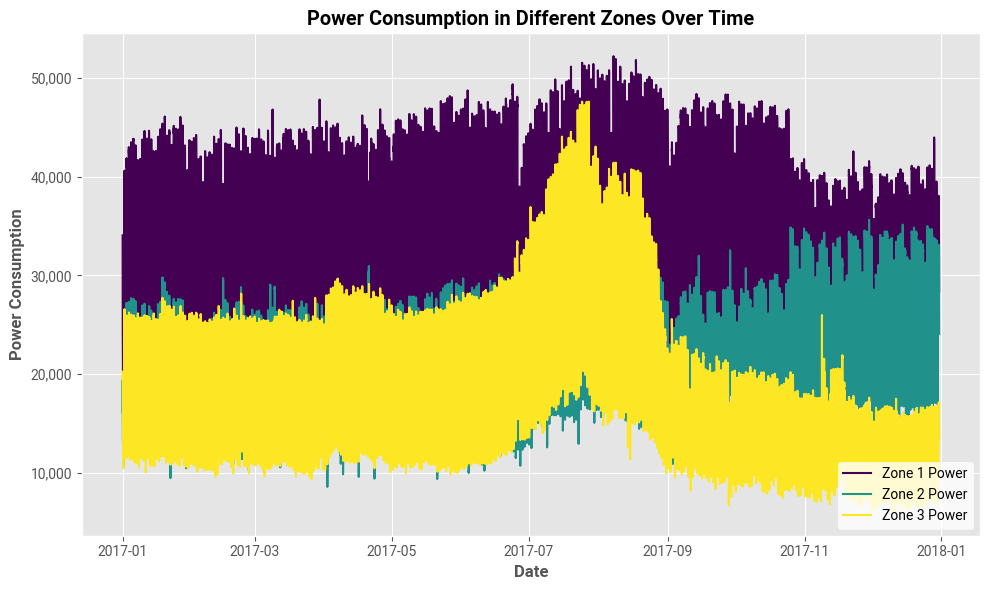

In [35]:
# Time series plot for power consumption in each zone
fig, ax = plt.subplots(figsize=(10, 6))

for i, zone in enumerate(zones):
    ax.plot(tetouan_power["datetime"], tetouan_power[zone],
         label=f"Zone {i+1} Power", color=viridis_zones[i])    

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xlabel('Date')
ax.set_ylabel('Power Consumption')
ax.set_title('Power Consumption in Different Zones Over Time')

plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

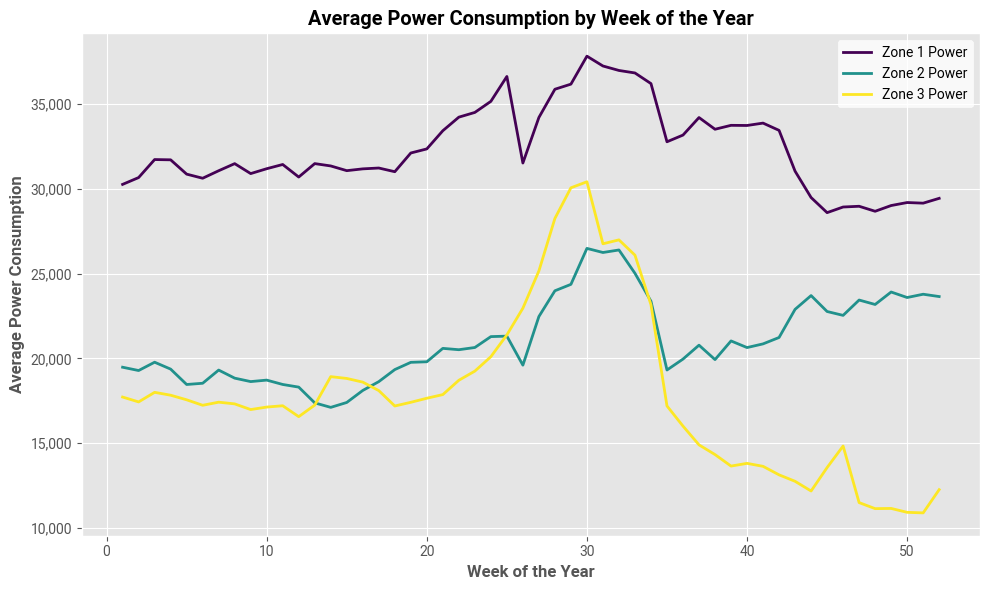

In [36]:
# Calculate the weekly mean power consumption for each zone
avg_power_by_week = tetouan_power.groupby(
    "weekofyear")[["zone_1_power", "zone_2_power", "zone_3_power"]].mean()

# Plot the average power consumption by week of the year
fig, ax = plt.subplots(figsize=(10, 6))

# Use a loop to plot each zone's data with viridis colors
for zone, color in zip(zones, viridis_zones):
    ax.plot(avg_power_by_week.index,
             avg_power_by_week[zone], label=f"{zone.replace('_', ' ').title()}", color=color, linewidth=2)

# Add labels and title
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
plt.xlabel('Week of the Year')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption by Week of the Year')
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

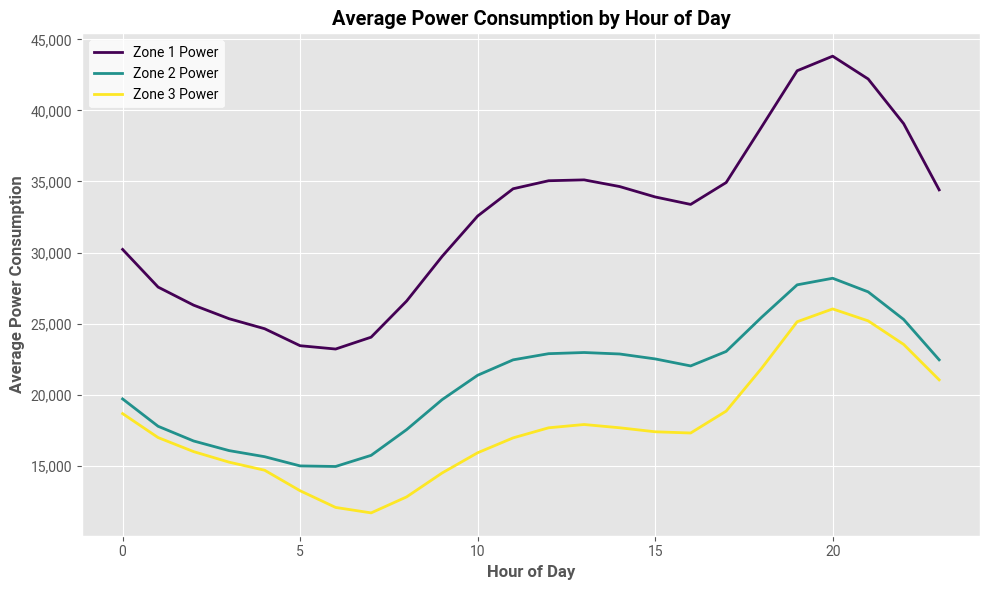

In [37]:
# Average power consumption by hour of the day
avg_power_by_hour = tetouan_power.groupby(
    "hour")[["zone_1_power", "zone_2_power", "zone_3_power"]].mean()

# Plot the average power consumption by hour of the day
fig, ax = plt.subplots(figsize=(10, 6))

# Use a loop to plot each zone's data
for zone, color in zip(zones, viridis_zones):
    ax.plot(avg_power_by_hour.index,
             avg_power_by_hour[zone], label=f"{zone.replace('_', ' ').title()}", color=color, linewidth=2)

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

plt.xlabel('Hour of Day')
plt.ylabel('Average Power Consumption')
plt.title('Average Power Consumption by Hour of Day')
plt.legend()
plt.tight_layout()
plt.show()

In [38]:
# A function to produce sampling distributions of sample means
def sampling_dist_mean(a, n: int, num_samples: int):
    """A function for generating sampling distributions fo sample means

    Args:
        a (np.array | pd.Series): An np.array or pd.Series of data to sample.
        n (int): The number of data points to sample per iteration.
        num_samples (int): The number of sampling iterations.

    Returns:
        np.array: An array of sample means of length num_samples.
    """
    return [np.random.choice(a, size=n).mean() for _ in np.arange(num_samples)]

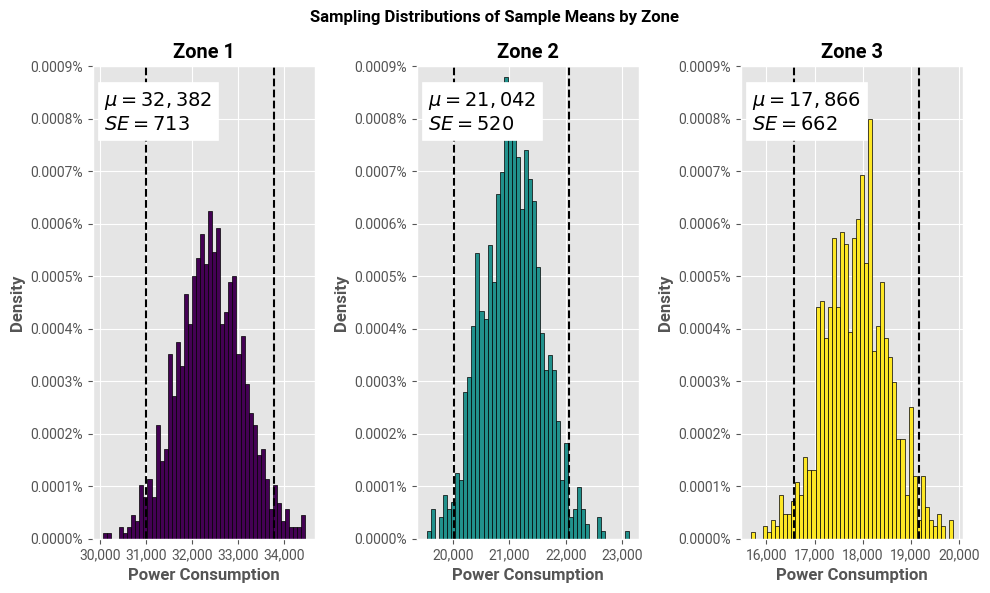

In [39]:
# Simulate random sampling from a uniform distribution for each zone
num_samples = 1000
n = 100

# Create histograms to visualize the uniform distribution for each zone
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

for i, zone in enumerate(zones):
    data = sampling_dist_mean(tetouan_power[zone], n, num_samples)
    output_space = np.linspace(
        np.min(tetouan_power[zone]), np.max(tetouan_power[zone]), num_samples)

    sd = np.std(tetouan_power[zone])
    mu = np.mean(data)
    se = sd / np.sqrt(n)

    ax[i].hist(data, bins=50, color=viridis_zones[i],
               ec="black", density=True)

    ax[i].vlines(mu-1.96*se, 0, 0.014, color="black", linestyles="dashed")
    ax[i].vlines(mu+1.96*se, 0, 0.014, color="black", linestyles="dashed")

    ax[i].set_title(f"Zone {i+1}")
    ax[i].set_xlabel("Power Consumption")
    ax[i].xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    ax[i].set_ylim([0, 0.0009])
    ax[i].yaxis.set_major_formatter(ticker.PercentFormatter(decimals=4))
    ax[i].set_ylabel("Density")

    textstr = '\n'.join((
        r'$\mu={:,.0f}$'.format(mu),
        r'$SE={:.0f}$'.format(se),
    ))
    
    ax[i].text(0.05, 0.95, textstr, transform=ax[i].transAxes, fontsize=14,
               verticalalignment='top', bbox=dict(fc="white", ec="white"))

# Display the charts
fig.suptitle(
    'Sampling Distributions of Sample Means by Zone')
plt.tight_layout()
plt.show()

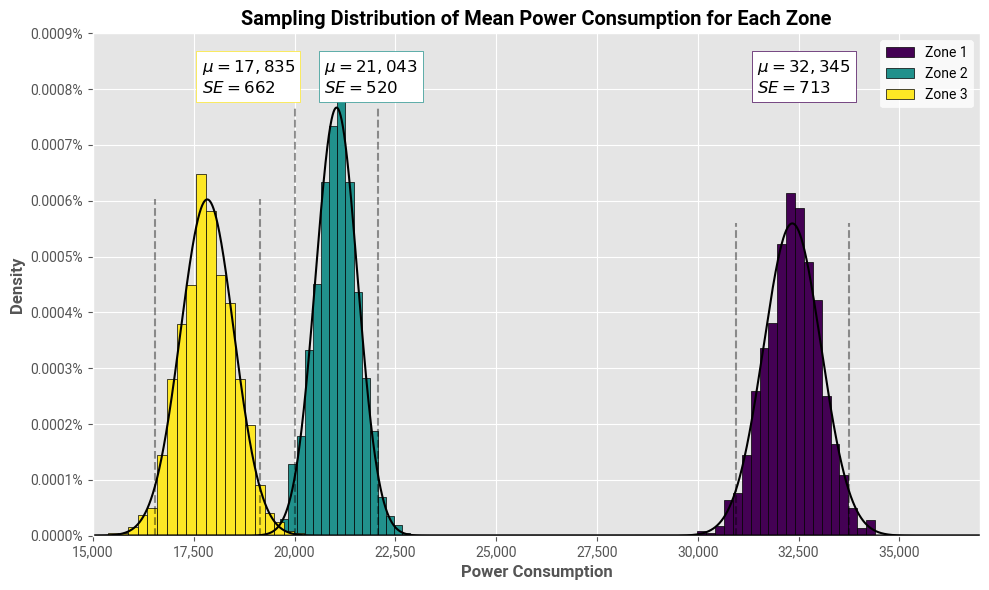

In [40]:
# Sampling and plotting parameters
num_samples = 1000
n = 100

x_lim = [15000, 37000]
y_lim = [0, .0009]

# Plot the sampling distributions
fig, ax = plt.subplots(figsize=(10, 6))

for i, zone in enumerate(zones):
    # Identify key parameters
    sd = np.std(tetouan_power[zone])
    mu = np.mean(tetouan_power[zone])
    se = sd / np.sqrt(n)

    # Create a normal distribution
    x_vals = np.arange(tetouan_power[zone].min(), tetouan_power[zone].max(), 1)
    norm = stats.norm.pdf(x_vals, loc=mu, scale=se)

    # Create sampling distribution
    sampling_dist = sampling_dist_mean(tetouan_power[zone], n, num_samples)

    ax.hist(sampling_dist, bins=20, density=True,
            color=viridis_zones[i], label=f"Zone {i+1}", ec="black", alpha=1)

    #
    ax.plot(x_vals, norm, color="black")

    # Plot 95% confidence intervals
    ax.vlines(mu-1.96*se, 0, norm.max(),
              color="black", linestyles="dashed", alpha=0.4)
    ax.vlines(mu+1.96*se, 0, norm.max(),
              color="black", linestyles="dashed", alpha=0.4)

    # Text boxes
    textstr = '\n'.join((
        r'$\mu={:,.0f}$'.format(mu),
        r'$SE={:.0f}$'.format(se),
    ))

    box_pos = (mu-x_lim[0])/(x_lim[1]-x_lim[0])*.95
    ax.text(box_pos, 0.95, textstr, transform=ax.transAxes, fontsize=12,
            verticalalignment="top",
            bbox=dict(fc="white", ec=viridis_zones[i], alpha=1))

# Axis format
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xlim(x_lim)

ax.yaxis.set_major_formatter(ticker.PercentFormatter(decimals=4))
ax.set_ylim(y_lim)

# Labels, title, and legend
plt.xlabel("Power Consumption")
plt.ylabel("Density")
plt.title(
    "Sampling Distribution of Mean Power Consumption for Each Zone", weight="bold")
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()

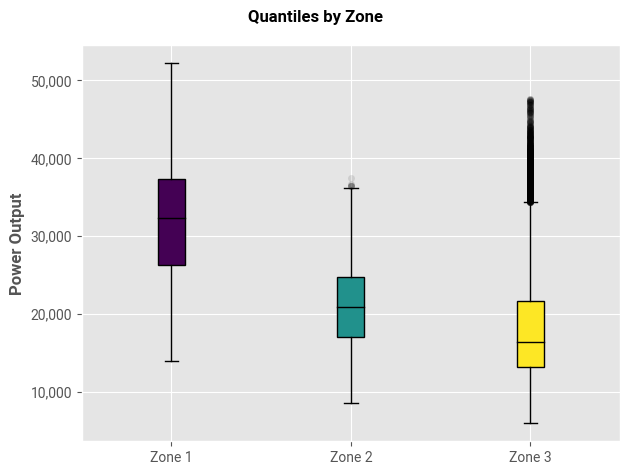

In [41]:
# Quantiles by Zone
fig, ax = plt.subplots()

[ax.boxplot(tetouan_power[zone], positions=[i+1], patch_artist=True,
            boxprops=dict(facecolor=viridis_zones[i]),
            flierprops=dict(alpha=0.1)) for i, zone in enumerate(zones)]

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

ax.set_xticklabels(["Zone 1", "Zone 2", "Zone 3"])
ax.set_ylabel("Power Output")

fig.suptitle("Quantiles by Zone")
fig.tight_layout()
plt.show()

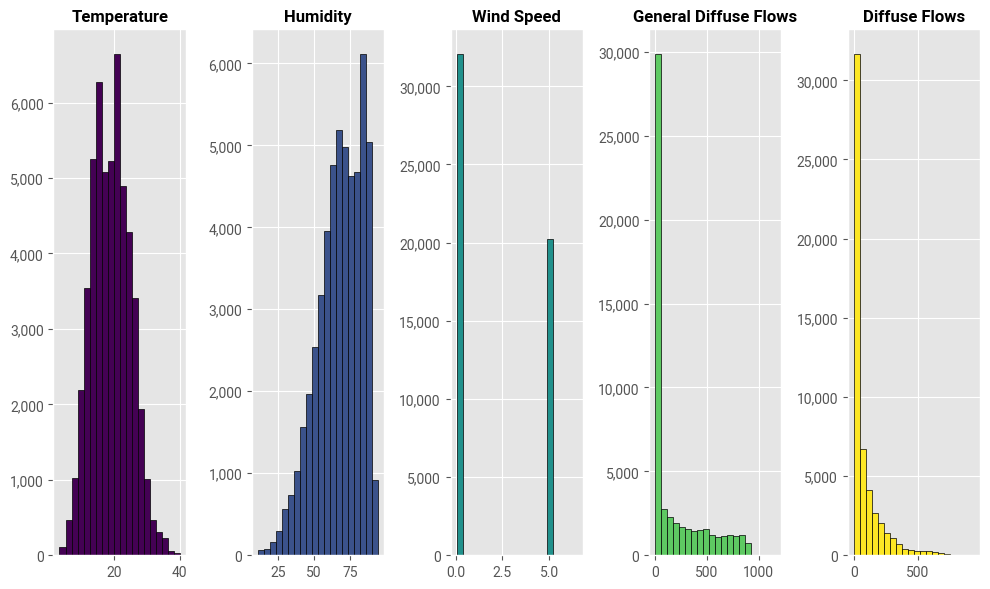

In [42]:
# Plotting histograms for each weather feature
fig, ax = plt.subplots(1, len(common_feats), figsize=(10, 6))

for i, feature in enumerate(common_feats):
    ax[i].hist(tetouan_power[feature], bins=20, color=viridis_cf[i], ec="black")
    ax[i].set_title(common_feats[i].replace("_", " ").title(), fontsize=12)
    ax[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))


fig.tight_layout()
plt.show()

In [43]:
# Kolmogorov-Smirnov Tests
kst_cols = [{"feature": f, "stat": s, "p-value": p} for f, (s, p) in [(feature, stats.kstest(
    tetouan_power[feature].sample(1000), 'norm')) for feature in common_feats]]

pd.DataFrame(kst_cols)

,feature,stat,p-value
0,temperature,0.999875,0.000000e+00
1,humidity,1.000000,0.000000e+00
2,wind_speed,0.525117,2.057099e-257
3,general_diffuse_flows,0.519324,2.478704e-251
4,diffuse_flows,0.515142,5.335910e-247


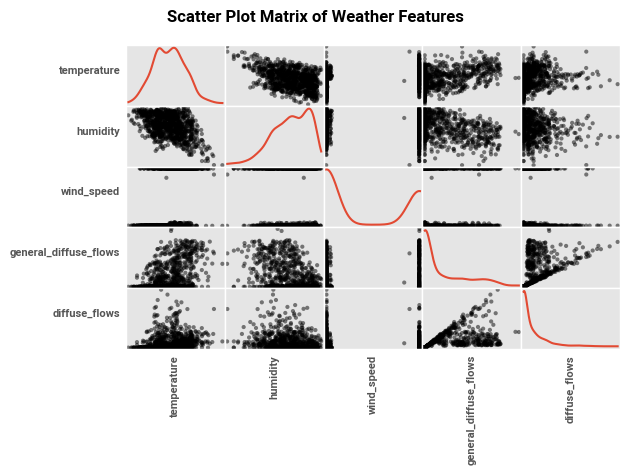

In [44]:
axes = pd.plotting.scatter_matrix(
    tetouan_power[common_feats].sample(n=1000), diagonal="kde", c="black")

for ax in axes.flatten():
    ax.xaxis.label.set_rotation(90)
    ax.xaxis.label.set_fontsize(8)
    ax.set_xticks([])

    ax.yaxis.label.set_rotation(0)
    ax.yaxis.label.set_fontsize(8)
    ax.yaxis.label.set_ha('right')
    ax.set_yticks([])

plt.suptitle("Scatter Plot Matrix of Weather Features")
plt.tight_layout()
plt.gcf().subplots_adjust(wspace=0, hspace=0)
plt.show()

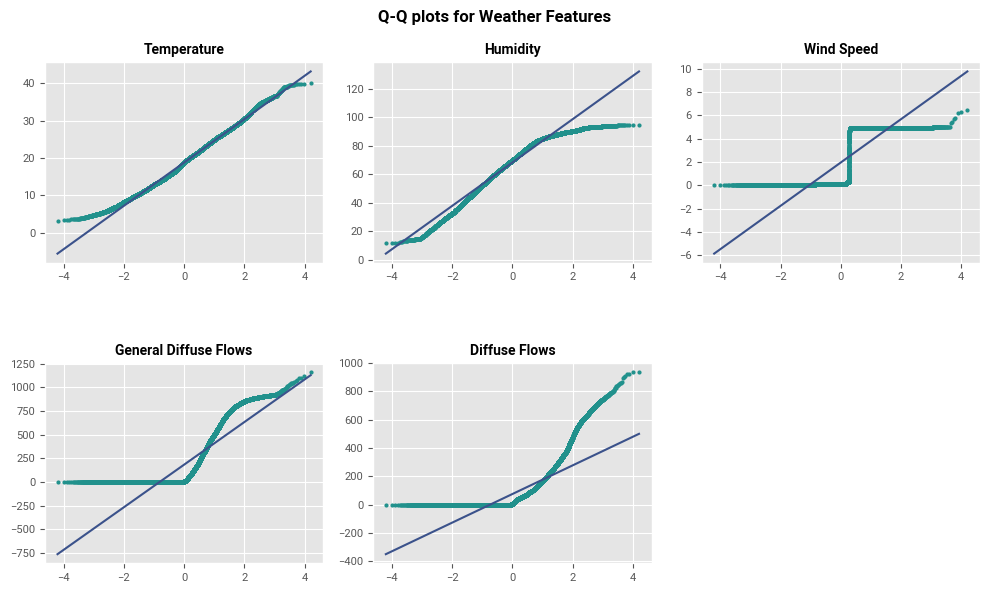

In [45]:
# QQ Plots for each weather feature
fig, ax = plt.subplots(2, 3, figsize=(10, 6))

ax_flat = ax.flatten()

[stats.probplot(tetouan_power[feat], plot=ax_flat[i])
 for i, feat in enumerate(common_feats)]

# Loop through styling
for i, axis in enumerate(ax_flat):
    try:
        axis.set_title(
            f"{common_feats[i].replace('_', ' ').title()}", fontsize=10)
        axis.get_lines()[0].set_markersize(2)
        axis.set_ylabel("")
        axis.set_xlabel("")
        axis.tick_params(axis='both', which='major', labelsize=8)
        axis.get_lines()[0].set_color(viridis_cf[2])
        axis.get_lines()[1].set_color(viridis_cf[1])

    except:
        pass

ax_flat[-1].axis('off')

fig.suptitle("Q-Q plots for Weather Features")
fig.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.show()

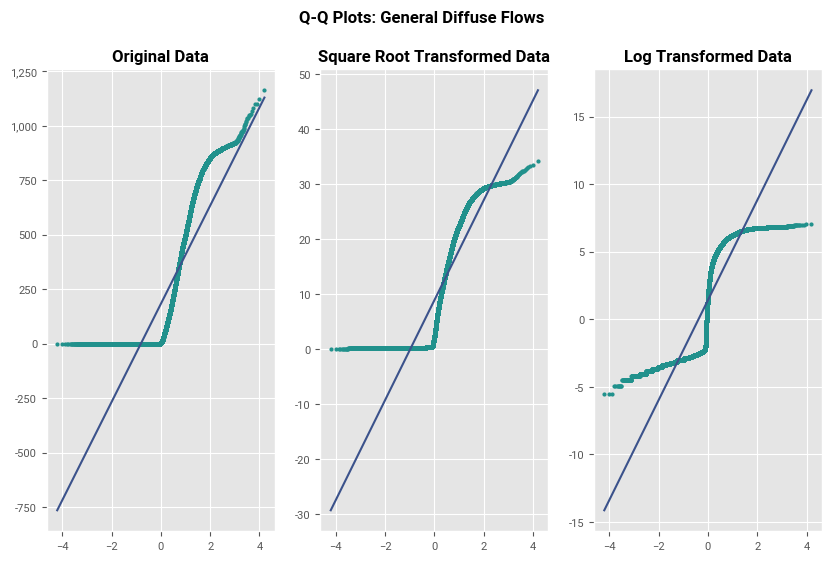

In [46]:
# General Diffuse flows adjustment
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

pp = [stats.probplot(tetouan_power["general_diffuse_flows"], plot=ax[0]),
      stats.probplot(
          np.sqrt(tetouan_power["general_diffuse_flows"]), plot=ax[1]),
      stats.probplot(np.log(tetouan_power["general_diffuse_flows"]), plot=ax[2])]

ax[0].set_title("Original Data", fontsize=12)
ax[1].set_title("Square Root Transformed Data", fontsize=12)
ax[2].set_title("Log Transformed Data", fontsize=12)

# Loop through styling
for i, axis in enumerate(ax):
    try:
        axis.get_lines()[0].set_markersize(2)
        axis.set_ylabel("")
        axis.set_xlabel("")
        axis.tick_params(axis='both', which='major', labelsize=8)
        axis.get_lines()[0].set_color(viridis_cf[2])
        axis.get_lines()[1].set_color(viridis_cf[1])
        axis.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    except:
        pass

fig.suptitle("Q-Q Plots: General Diffuse Flows")
plt.show()

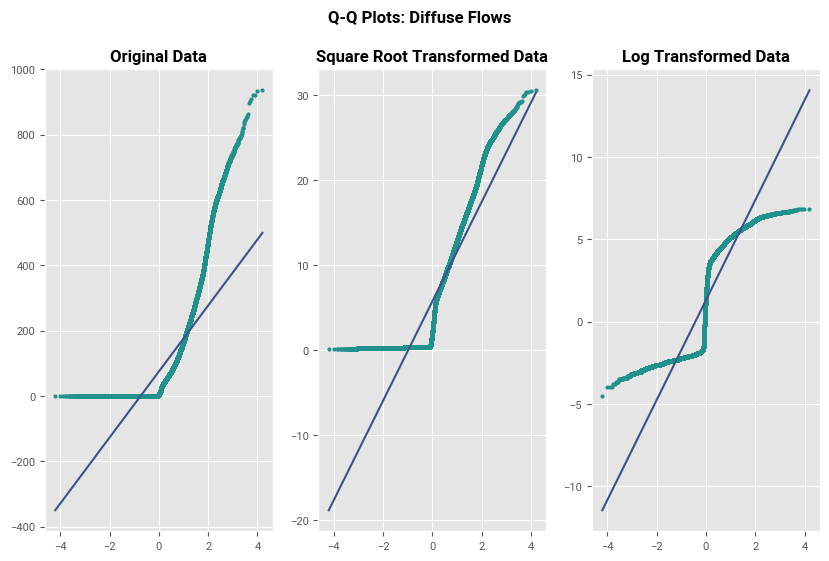

In [47]:
# Diffuse flows adjustment
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

pp = [stats.probplot(tetouan_power["diffuse_flows"], plot=ax[0]),
      stats.probplot(np.sqrt(tetouan_power["diffuse_flows"]), plot=ax[1]),
      stats.probplot(np.log(tetouan_power["diffuse_flows"]), plot=ax[2])]

ax[0].set_title("Original Data", fontsize=12)
ax[1].set_title("Square Root Transformed Data", fontsize=12)
ax[2].set_title("Log Transformed Data", fontsize=12)

# Loop through styling
for i, axis in enumerate(ax):
    try:
        axis.get_lines()[0].set_markersize(2)
        axis.set_ylabel("")
        axis.set_xlabel("")
        axis.tick_params(axis='both', which='major', labelsize=8)
        axis.get_lines()[0].set_color(viridis_cf[2])
        axis.get_lines()[1].set_color(viridis_cf[1])
        ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    except:
        pass

fig.suptitle("Q-Q Plots: Diffuse Flows")
plt.show()

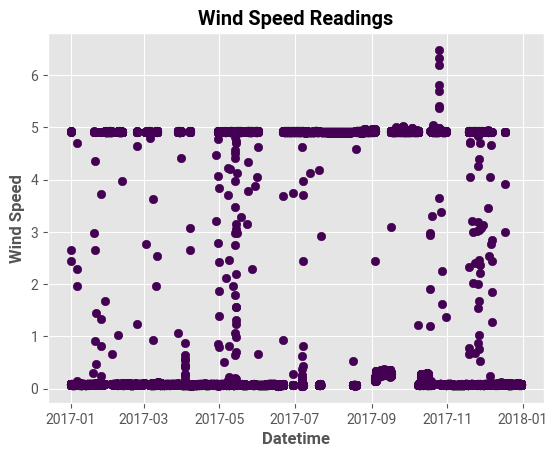

In [48]:
# Wind speed scatter
fig, ax = plt.subplots()

ax.scatter(tetouan_power["datetime"],
           tetouan_power["wind_speed"], facecolors=viridis_cf[0])
ax.set_title("Wind Speed Readings")
ax.set_xlabel("Datetime")
ax.set_ylabel("Wind Speed")
plt.show()

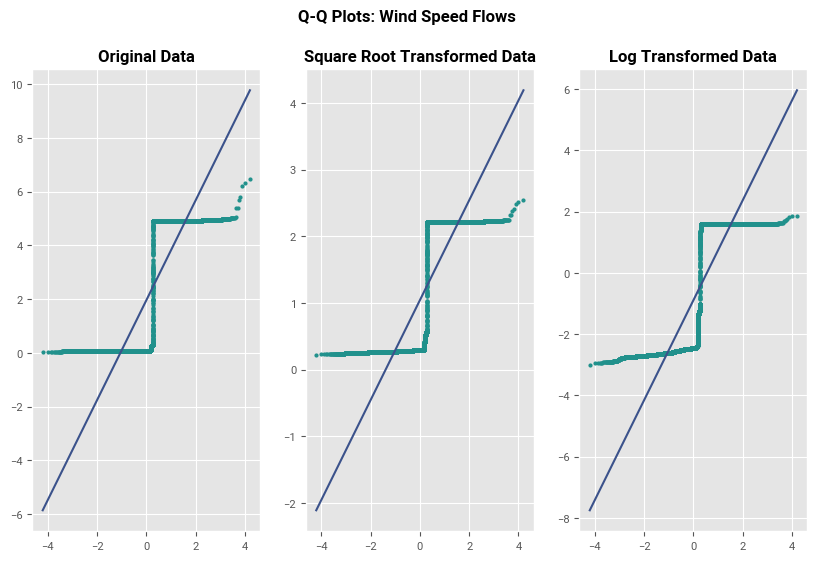

In [49]:
# Wind Speed adjustment
fig, ax = plt.subplots(1, 3, figsize=(10, 6))

pp = [stats.probplot(tetouan_power["wind_speed"], plot=ax[0]),
      stats.probplot(np.sqrt(tetouan_power["wind_speed"]), plot=ax[1]),
      stats.probplot(np.log(tetouan_power["wind_speed"]), plot=ax[2])]


ax[0].set_title("Original Data", fontsize=12)
ax[1].set_title("Square Root Transformed Data", fontsize=12)
ax[2].set_title("Log Transformed Data", fontsize=12)

# Loop through styling
for i, axis in enumerate(ax):
    try:
        axis.get_lines()[0].set_markersize(2)
        axis.set_ylabel("")
        axis.set_xlabel("")
        axis.tick_params(axis='both', which='major', labelsize=8)
        axis.get_lines()[0].set_color(viridis_cf[2])
        axis.get_lines()[1].set_color(viridis_cf[1])

    except:
        pass

fig.suptitle("Q-Q Plots: Wind Speed Flows")
plt.show()

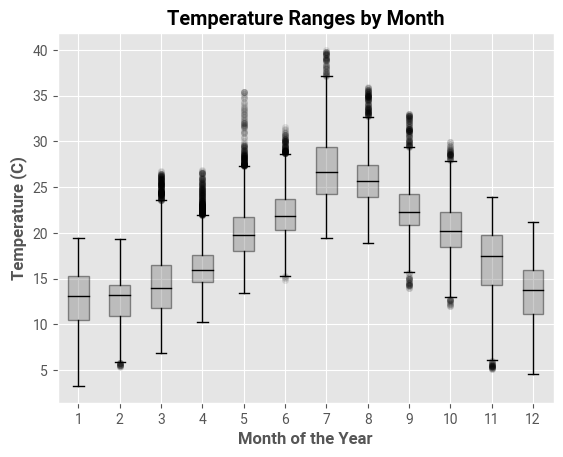

In [50]:
# Temperature by Month
fig, ax = plt.subplots()

ax.boxplot([tetouan_power["temperature"].loc[tetouan_power["month"] == i] for i in np.arange(1, 13)],
           patch_artist=True,
           boxprops=dict(facecolor="gray", alpha=0.4),
           flierprops=dict(alpha=0.1))

ax.set_xlabel("Month of the Year")
ax.set_ylabel("Temperature (C)")

plt.title("Temperature Ranges by Month")
plt.show()

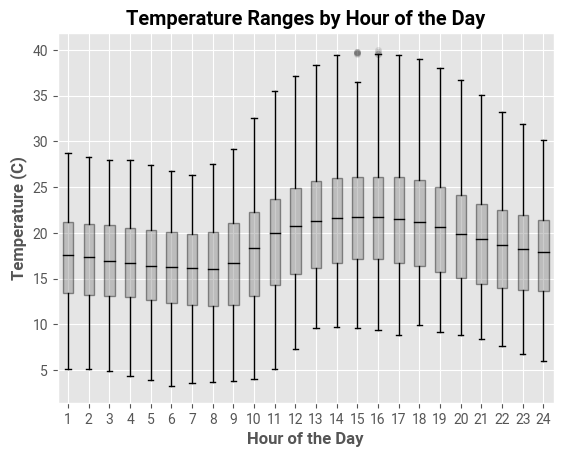

In [51]:
# Temperature by Hour
fig, ax = plt.subplots()

ax.boxplot([tetouan_power["temperature"].loc[tetouan_power["hour"] == i]
           for i in np.arange(0, 24)],
           patch_artist=True,
           boxprops=dict(facecolor="gray", alpha=0.4),
           flierprops=dict(alpha=0.1))

ax.set_xlabel("Hour of the Day")
ax.set_ylabel("Temperature (C)")

plt.title("Temperature Ranges by Hour of the Day")
plt.show()

# Regression Analysis

In [52]:
tetouan_power[zones + ["total_power"]].corr()

,zone_1_power,zone_2_power,zone_3_power,total_power
zone_1_power,1.000000,0.834519,0.750733,0.959146
zone_2_power,0.834519,1.000000,0.570932,0.871069
zone_3_power,0.750733,0.570932,1.000000,0.871777
total_power,0.959146,0.871069,0.871777,1.000000


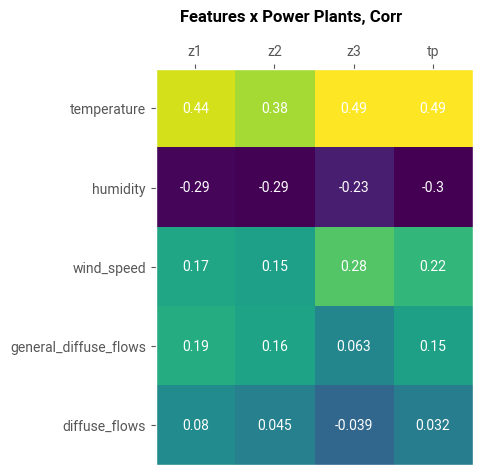

In [53]:

# Function to calculate correlations for a given power zone
def get_corr(zone):
    return tetouan_power[common_feats + [zone]].corr().loc[pd.Index(common_feats), zone]

# Calculate correlations for each power zone and total power
corr_data = {zone: get_corr(zone) for zone in zones_all}

# Create a DataFrame from the correlation data
corr_df = pd.DataFrame({
    "z1": corr_data["zone_1_power"],
    "z2": corr_data["zone_2_power"],
    "z3": corr_data["zone_3_power"],
    "tp": corr_data["total_power"]
})

# Plotting
fig, ax = plt.subplots()

ax.imshow(corr_df)

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticks(np.arange(corr_df.shape[1]), labels=corr_df.columns)
ax.set_yticks(np.arange(corr_df.shape[0]), labels=common_feats)
ax.grid(False)

# Loop over data dimensions and create text annotations
for i in range(corr_df.shape[0]):
    for j in range(corr_df.shape[1]):
        text = ax.text(j, i, f"{corr_df.iloc[i, j]:.2}",
                       ha="center", va="center", color="w")

plt.suptitle("Features x Power Plants, Corr")
plt.tight_layout()
plt.show()

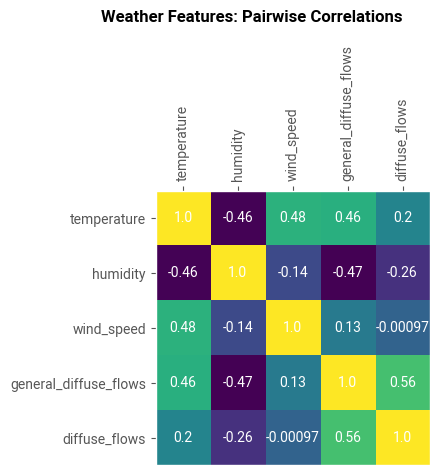

In [54]:
# Plot pairwise Corrplot of weather features 
cf_corr = tetouan_power[common_feats].corr()

fig, ax = plt.subplots()

ax.imshow(cf_corr)

ax.tick_params(top=True, labeltop=True, bottom=False, labelbottom=False)
ax.set_xticks(np.arange(cf_corr.shape[1]), labels=common_feats)
ax.set_yticks(np.arange(cf_corr.shape[0]), labels=common_feats)
ax.grid(False)

# Loop over data dimensions and create text annotations
for i in range(cf_corr.shape[0]):
    for j in range(cf_corr.shape[1]):
        text = ax.text(j, i, f"{cf_corr.iloc[i, j]:.2}",
                       ha="center", va="center", color="w")

plt.xticks(rotation=90)
plt.suptitle("Weather Features: Pairwise Correlations")
plt.tight_layout()
plt.show()

In [55]:
# A Function to output key OLS output
def output_summary(lm):
    return {"rsquare": lm.rsquared,
            "adj_rsquare": lm.rsquared_adj,
            "f_pvalue": lm.f_pvalue,
            "aic": lm.aic}

In [56]:
# Testing Different Model Types - Zone 1
lm_test_zone_1_1 = smf.ols(formula="zone_1_power ~ hour ",
                           data=tetouan_power).fit()

lm_test_zone_1_2 = smf.ols(formula="zone_1_power ~ month + hour ",
                           data=tetouan_power).fit()

lm_test_zone_1_3 = smf.ols(formula="zone_1_power ~ \
                       month + day_of_week + hour + temperature",
                           data=tetouan_power).fit()

lm_test_zone_1_4 = smf.ols(formula="zone_1_power ~ \
                       month + day_of_week + hour + minute_of_day + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                           data=tetouan_power).fit()

lm_test_zone_1_5 = smf.ols(formula="zone_1_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                           data=tetouan_power).fit()

lm_test_zone_1_6 = smf.ols(formula="zone_1_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + np.log(wind_speed) + \
                       general_diffuse_flows + np.sqrt(diffuse_flows)",
                           data=tetouan_power).fit()


lm_test_zone_1_1.summary()
lm_test_zone_1_1.f_pvalue


lm_zone_1_test_models = [lm_test_zone_1_1, lm_test_zone_1_2, lm_test_zone_1_3,
                  lm_test_zone_1_4, lm_test_zone_1_5, lm_test_zone_1_6]

model_names = ["LMZ1_H", "LMZ1_MH", "LMZ1_MDHT", "LMZ1_MDHM_W", "LMZ1_MDH_W", "LMZ1_MDH_TW"]
lm_zone_1_test_output = [output_summary(model) for model in lm_zone_1_test_models]


pd.DataFrame(lm_zone_1_test_output, index=model_names)

,rsquare,adj_rsquare,f_pvalue,aic
LMZ1_H,0.529915,0.529906,0.0,1.039272e+06
LMZ1_MH,0.529943,0.529925,0.0,1.039271e+06
LMZ1_MDHT,0.635136,0.635108,0.0,1.025997e+06
LMZ1_MDHM_W,0.644125,0.644064,0.0,1.024699e+06
LMZ1_MDH_W,0.644125,0.644070,0.0,1.024697e+06
LMZ1_MDH_TW,0.646252,0.646198,0.0,1.024383e+06


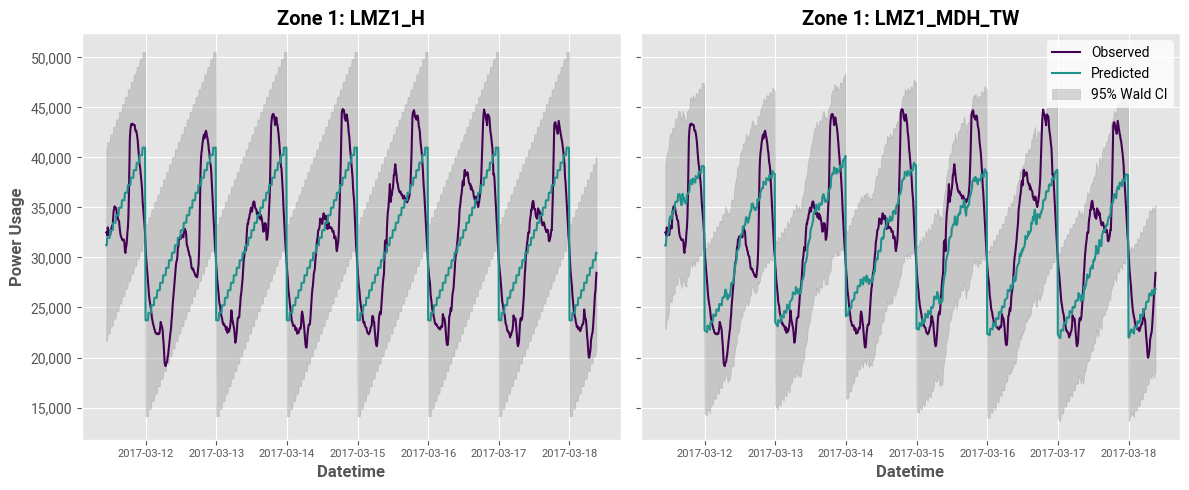

In [57]:

# A side-by-side comparison on the simplest and most complex model
models = [lm_test_zone_1_1, lm_test_zone_1_6]
model_titles = ["Zone 1: LMZ1_H", "Zone 1: LMZ1_MDH_TW"]

sample = tetouan_power[10000:11000]

fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

colors = viridis_cf

for i, model in enumerate(models):
    pred = model.get_prediction(sample).summary_frame()

    axs[i].plot(sample["datetime"], sample["zone_1_power"], color=colors[0], label="Observed")
    axs[i].plot(sample["datetime"], pred["mean"], color=colors[2], label="Predicted")

    axs[i].set_title(model_titles[i])
    axs[i].set_xlabel("Datetime")
    axs[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    [tick.set_fontsize(8) for tick in axs[i].get_xticklabels()]

    axs[i].fill_between(sample["datetime"], pred["obs_ci_lower"], pred["obs_ci_upper"],
                        where=(pred["obs_ci_lower"] <= pred["obs_ci_upper"]),
                        interpolate=True, color='gray', alpha=0.3, label="95% Wald CI")

axs[0].set_ylabel("Power Usage")

axs[1].legend()

fig.tight_layout()
plt.show()


In [58]:
# Testing Different Model Types - Zone 2
lm_test_zone_2_1 = smf.ols(formula="zone_2_power ~ hour ",
                           data=tetouan_power).fit()

lm_test_zone_2_2 = smf.ols(formula="zone_2_power ~ month + hour ",
                           data=tetouan_power).fit()

lm_test_zone_2_3 = smf.ols(formula="zone_2_power ~ \
                       month + day_of_week + hour + temperature",
                           data=tetouan_power).fit()

lm_test_zone_2_4 = smf.ols(formula="zone_2_power ~ \
                       month + day_of_week + hour + minute_of_day + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                           data=tetouan_power).fit()

lm_test_zone_2_5 = smf.ols(formula="zone_2_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                           data=tetouan_power).fit()

lm_test_zone_2_6 = smf.ols(formula="zone_2_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + np.log(wind_speed) + \
                       general_diffuse_flows + np.sqrt(diffuse_flows)",
                           data=tetouan_power).fit()


lm_test_zone_2_1.summary()
lm_test_zone_2_1.f_pvalue

lm_zone_2_test_models = [lm_test_zone_2_1, lm_test_zone_2_2, lm_test_zone_2_3,
                  lm_test_zone_2_4, lm_test_zone_2_5, lm_test_zone_2_6]

model_names = ["LMZ2_H", "LMZ2_MH", "LMZ2_MDHT", "LMZ2_MDHM_W", "LMZ2_MDH_W", "LMZ2_MDH_TW"]
lm_zone_2_test_output = [output_summary(model) for model in lm_zone_2_test_models]


pd.DataFrame(lm_zone_2_test_output, index=model_names)

,rsquare,adj_rsquare,f_pvalue,aic
LMZ2_H,0.440045,0.440035,0.0,1.015373e+06
LMZ2_MH,0.542616,0.542598,0.0,1.004769e+06
LMZ2_MDHT,0.586778,0.586746,0.0,9.994511e+05
LMZ2_MDHM_W,0.594466,0.594397,0.0,9.984766e+05
LMZ2_MDH_W,0.594465,0.594403,0.0,9.984747e+05
LMZ2_MDH_TW,0.595084,0.595022,0.0,9.983947e+05


In [59]:
# Testing Different Model Types - Zone 3
lm_test_zone_3_1 = smf.ols(formula="zone_3_power ~ hour ",
                           data=tetouan_power).fit()

lm_test_zone_3_2 = smf.ols(formula="zone_3_power ~ month + hour ",
                           data=tetouan_power).fit()

lm_test_zone_3_3 = smf.ols(formula="zone_3_power ~ \
                       month + day_of_week + hour + temperature",
                           data=tetouan_power).fit()

lm_test_zone_3_4 = smf.ols(formula="zone_3_power ~ \
                       month + day_of_week + hour + minute_of_day + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                           data=tetouan_power).fit()

lm_test_zone_3_5 = smf.ols(formula="zone_3_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                           data=tetouan_power).fit()

lm_test_zone_3_6 = smf.ols(formula="zone_3_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + np.log(wind_speed) + \
                       general_diffuse_flows + np.sqrt(diffuse_flows)",
                           data=tetouan_power).fit()


lm_test_zone_3_1.summary()
lm_test_zone_3_1.f_pvalue

lm_zone_3_test_models = [lm_test_zone_3_1, lm_test_zone_3_2, lm_test_zone_3_3,
                  lm_test_zone_3_4, lm_test_zone_3_5, lm_test_zone_3_6]

model_names = ["LMZ3_H", "LMZ3_MH", "LMZ3_MDHT", "LMZ3_MDHM_W", "LMZ3_MDH_W", "LMZ3_MDH_TW"]
lm_zone_3_test_output = [output_summary(model) for model in lm_zone_3_test_models]


pd.DataFrame(lm_zone_3_test_output, index=model_names)

,rsquare,adj_rsquare,f_pvalue,aic
LMZ3_H,0.206349,0.206334,0.0,1.058970e+06
LMZ3_MH,0.261070,0.261042,0.0,1.055227e+06
LMZ3_MDHT,0.508504,0.508467,0.0,1.033859e+06
LMZ3_MDHM_W,0.601321,0.601253,0.0,1.022898e+06
LMZ3_MDH_W,0.601309,0.601248,0.0,1.022898e+06
LMZ3_MDH_TW,0.614026,0.613967,0.0,1.021199e+06


In [60]:
lm_test_zone_1_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           zone_1_power   R-squared:                       0.646
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                 1.197e+04
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:15:07   Log-Likelihood:            -5.1218e+05
No. Observations:               52416   AIC:                         1.024e+06
Df Residuals:                   52407   BIC:                         1.024e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.857e+04    158.656    117.064      0.000    1.83e+04    1.89e+04
month                   -253.4262      5.759    -44.007      0.000    -264.713    -242.139
day_of_week             -236.2458      9.282    -25.452      0.000    -254.439    -218.053
hour                     698.1217      2.808    248.641      0.000     692.618     703.625
temperature              447.2676      4.549     98.326      0.000     438.352     456.183
humidity                   5.9789      1.446      4.134      0.000       3.145       8.813
np.log(wind_speed)        63.3054     10.814      5.854      0.000      42.110      84.501
general_diffuse_flows      0.3300      0.108      3.054      0.002       0.118       0.542
np.sqrt(diffuse_flows)  -125.6633      3.999    -31.426      0.000    -133.501    -117.826
==============================================================================
Omnibus:                      631.580   Durbin-Watson:                   0.117
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              739.132
Skew:                           0.215   Prob(JB):                    3.16e-161
Kurtosis:                       3.393   Cond. No.                     2.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [61]:
lm_test_zone_2_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           zone_2_power   R-squared:                       0.595
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     9627.
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:15:07   Log-Likelihood:            -4.9919e+05
No. Observations:               52416   AIC:                         9.984e+05
Df Residuals:                   52407   BIC:                         9.985e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               1.375e+04    123.821    111.046      0.000    1.35e+04     1.4e+04
month                    406.5407      4.494     90.457      0.000     397.732     415.350
day_of_week             -327.3475      7.244    -45.188      0.000    -341.546    -313.149
hour                     469.3094      2.191    214.172      0.000     465.014     473.604
temperature              129.8941      3.550     36.589      0.000     122.936     136.852
humidity                 -28.1226      1.129    -24.918      0.000     -30.335     -25.910
np.log(wind_speed)        33.6267      8.440      3.984      0.000      17.085      50.169
general_diffuse_flows      0.5903      0.084      7.000      0.000       0.425       0.756
np.sqrt(diffuse_flows)   -64.4831      3.121    -20.663      0.000     -70.600     -58.366
==============================================================================
Omnibus:                      408.648   Durbin-Watson:                   0.086
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              419.749
Skew:                           0.212   Prob(JB):                     7.12e-92
Kurtosis:                       3.113   Cond. No.                     2.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [62]:
lm_test_zone_3_6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           zone_3_power   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                 1.042e+04
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:15:07   Log-Likelihood:            -5.1059e+05
No. Observations:               52416   AIC:                         1.021e+06
Df Residuals:                   52407   BIC:                         1.021e+06
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept               6624.3296    153.909     43.040      0.000    6322.666    6925.993
month                   -876.5479      5.586   -156.906      0.000    -887.497    -865.598
day_of_week               42.9253      9.004      4.767      0.000      25.277      60.574
hour                     373.8618      2.724    137.260      0.000     368.523     379.200
temperature              741.2956      4.413    167.990      0.000     732.647     749.945
humidity                  10.6258      1.403      7.574      0.000       7.876      13.375
np.log(wind_speed)       205.7445     10.491     19.612      0.000     185.183     226.306
general_diffuse_flows     -3.2341      0.105    -30.850      0.000      -3.440      -3.029
np.sqrt(diffuse_flows)  -244.2089      3.879    -62.956      0.000    -251.812    -236.606
==============================================================================
Omnibus:                     2311.850   Durbin-Watson:                   0.046
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2861.856
Skew:                           0.477   Prob(JB):                         0.00
Kurtosis:                       3.633   Cond. No.                     2.77e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.77e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

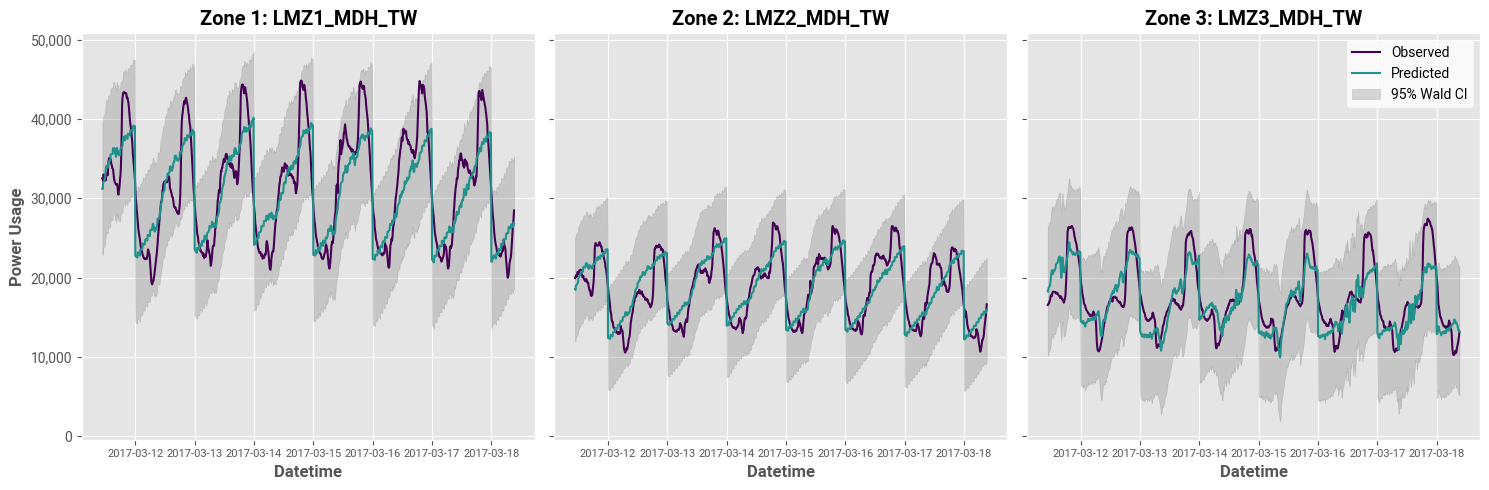

In [63]:
# Side-by-side plots of zones with sample predictions
models = [lm_test_zone_1_6, lm_test_zone_2_6, lm_test_zone_3_6]
model_titles = ["Zone 1: LMZ1_MDH_TW", "Zone 2: LMZ2_MDH_TW", "Zone 3: LMZ3_MDH_TW"]

sample = tetouan_power[10000:11000]

fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

colors = viridis_cf

for i, model in enumerate(models):
    # Get prediction summary for the current model
    pred = model.get_prediction(sample).summary_frame()

    # Plot observed and predicted values
    axs[i].plot(sample["datetime"], sample[zones[i]], color=colors[0], label="Observed")
    axs[i].plot(sample["datetime"], pred["mean"], color=colors[2], label="Predicted")

    # Set title, labels, and format the y-axis
    axs[i].set_title(model_titles[i])
    axs[i].set_xlabel("Datetime")
    axs[i].yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    [tick.set_fontsize(8) for tick in axs[i].get_xticklabels()]

    # Fill between the confidence intervals
    axs[i].fill_between(sample["datetime"], pred["obs_ci_lower"], pred["obs_ci_upper"],
                        where=(pred["obs_ci_lower"] <= pred["obs_ci_upper"]),
                        interpolate=True, color='gray', alpha=0.3, label="95% Wald CI")

# Set shared ylabel for all subplots
axs[0].set_ylabel("Power Usage")

# Add legend on the last subplot (to avoid overlap)
axs[2].legend()

# Adjust layout for spacing
fig.tight_layout()

# Show the plot
plt.show()

In [64]:
# Accuracy measures for Zone 1 MV LM
models = [lm_test_zone_1_6, lm_test_zone_2_6, lm_test_zone_3_6]
model_names = ["LMZ1_MDH_TW", "LMZ2_MDH_TW", "LMZ3_MDH_TW"]

mae = [metrics.mean_absolute_error(tetouan_power[zone], model.predict(tetouan_power)) for zone, model in zip(zones, models)]
mape = [metrics.mean_absolute_percentage_error(tetouan_power[zone], model.predict(tetouan_power)) for zone, model in zip(zones, models)]

pd.DataFrame({"MAE": mae, "MAPE": mape}, index=model_names)

,MAE,MAPE
LMZ1_MDH_TW,3368.444256,0.108177
LMZ2_MDH_TW,2614.994713,0.130603
LMZ3_MDH_TW,3241.951010,0.198511


In [65]:
# Cross validation
# Splitting data into train and test
train, test = train_test_split(tetouan_power, test_size=0.33, random_state=42)

# Fitting models with training data
lm_test_zone_1_6_cv = smf.ols(formula="zone_1_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + np.log(wind_speed) + \
                       general_diffuse_flows + np.sqrt(diffuse_flows)",
                              data=train).fit()

lm_test_zone_2_6_cv = smf.ols(formula="zone_2_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + np.log(wind_speed) + \
                       general_diffuse_flows + np.sqrt(diffuse_flows)",
                              data=train).fit()

lm_test_zone_3_6_cv = smf.ols(formula="zone_3_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + np.log(wind_speed) + \
                       general_diffuse_flows + np.sqrt(diffuse_flows)",
                              data=train).fit()


# Accuracy measures for Zone 1 MV LM
models = [lm_test_zone_1_6_cv, lm_test_zone_2_6_cv, lm_test_zone_3_6_cv]
model_names = ["LMZ1_MDH_TW", "LMZ2_MDH_TW", "LMZ3_MDH_TW"]

mae = [metrics.mean_absolute_error(test[zone], model.predict(
    test)) for zone, model in zip(zones, models)]
mape = [metrics.mean_absolute_percentage_error(
    test[zone], model.predict(test)) for zone, model in zip(zones, models)]

pd.DataFrame({"MAE": mae, "MAPE": mape}, index=model_names)

,MAE,MAPE
LMZ1_MDH_TW,3362.685126,0.107801
LMZ2_MDH_TW,2624.449261,0.130977
LMZ3_MDH_TW,3233.880419,0.196823


In [66]:
# Cross validation - Scaled Data
# Splitting data into train and test
scaler = StandardScaler()
scaler.fit(tetouan_power.drop("datetime", axis=1))

# Dropping datetime and making transformation ahead of scaling
scaled_data = tetouan_power.drop("datetime", axis=1)
scaled_data["wind_speed"] = np.log(scaled_data["wind_speed"])
scaled_data["diffuse_flows"] = np.log(scaled_data["diffuse_flows"])

scaled_data = pd.DataFrame(scaler.transform(scaled_data),
                           columns=tetouan_power.columns.drop("datetime"))

scaled_data[zones_all] = tetouan_power[zones_all]

train, test = train_test_split(scaled_data, test_size=0.33, random_state=42)

# Fitting models with training data
lm_test_zone_1_6_cv_s = smf.ols(formula="zone_1_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                                data=train).fit()

lm_test_zone_2_6_cv_s = smf.ols(formula="zone_2_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                                data=train).fit()

lm_test_zone_3_6_cv_s = smf.ols(formula="zone_3_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                                data=train).fit()

lm_test_tp_6_cv_s = smf.ols(formula="total_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + wind_speed + \
                       general_diffuse_flows + diffuse_flows",
                            data=train).fit()

# Accuracy measures for Zone 1 MV LM
models = [lm_test_zone_1_6_cv_s, lm_test_zone_2_6_cv_s,
          lm_test_zone_3_6_cv_s, lm_test_tp_6_cv_s]

model_names = ["LMZ1_MDH_TW_S", "LMZ2_MDH_TW_S",
               "LMZ3_MDH_TW_S", "LMTP_MDH_TW_S"]

mae = [metrics.mean_absolute_error(test[zone], model.predict(
    test)) for zone, model in zip(zones_all, models)]

mape = [metrics.mean_absolute_percentage_error(test[zone], model.predict(
    test)) for zone, model in zip(zones_all, models)]

pd.DataFrame({"MAE": mae, "MAPE": mape}, index=model_names)

,MAE,MAPE
LMZ1_MDH_TW_S,3362.880970,0.107646
LMZ2_MDH_TW_S,2624.641229,0.130840
LMZ3_MDH_TW_S,3179.206010,0.192199
LMTP_MDH_TW_S,8097.758981,0.117527


In [67]:
lm_test_zone_1_6_cv_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           zone_1_power   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.643
Method:                 Least Squares   F-statistic:                     7923.
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:15:08   Log-Likelihood:            -3.4324e+05
No. Observations:               35118   AIC:                         6.865e+05
Df Residuals:                   35109   BIC:                         6.866e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept               1.61e+04    721.568     22.306      0.000    1.47e+04    1.75e+04
month                  -828.4305     24.191    -34.246      0.000    -875.845    -781.016
day_of_week            -472.5913     22.747    -20.776      0.000    -517.176    -428.007
hour                   4838.0309     23.897    202.454      0.000    4791.192    4884.870
temperature            2602.9637     32.505     80.080      0.000    2539.254    2666.674
humidity                104.7282     27.531      3.804      0.000      50.766     158.690
wind_speed              165.3830     31.031      5.330      0.000     104.561     226.205
general_diffuse_flows    84.5544     36.066      2.344      0.019      13.864     155.245
diffuse_flows          -2.77e+04   1211.529    -22.862      0.000   -3.01e+04   -2.53e+04
==============================================================================
Omnibus:                      452.492   Durbin-Watson:                   2.021
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              529.961
Skew:                           0.224   Prob(JB):                    8.33e-116
Kurtosis:                       3.403   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [68]:
lm_test_zone_2_6_cv_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           zone_2_power   R-squared:                       0.594
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     6422.
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:15:08   Log-Likelihood:            -3.3445e+05
No. Observations:               35118   AIC:                         6.689e+05
Df Residuals:                   35109   BIC:                         6.690e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept              1.251e+04    561.749     22.269      0.000    1.14e+04    1.36e+04
month                  1426.4644     18.833     75.743      0.000    1389.551    1463.377
day_of_week            -662.6369     17.709    -37.419      0.000    -697.346    -627.927
hour                   3257.2368     18.604    175.082      0.000    3220.772    3293.701
temperature             741.0839     25.305     29.286      0.000     691.485     790.683
humidity               -430.1999     21.433    -20.071      0.000    -472.210    -388.190
wind_speed               82.6687     24.158      3.422      0.001      35.318     130.019
general_diffuse_flows   161.3625     28.078      5.747      0.000     106.329     216.396
diffuse_flows         -1.452e+04    943.189    -15.399      0.000   -1.64e+04   -1.27e+04
==============================================================================
Omnibus:                      293.673   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              303.143
Skew:                           0.217   Prob(JB):                     1.49e-66
Kurtosis:                       3.140   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [69]:
lm_test_zone_3_6_cv_s.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           zone_3_power   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     7151.
Date:                Mon, 21 Oct 2024   Prob (F-statistic):               0.00
Time:                        00:15:08   Log-Likelihood:            -3.4176e+05
No. Observations:               35118   AIC:                         6.835e+05
Df Residuals:                   35109   BIC:                         6.836e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept             -2.207e+04    691.719    -31.911      0.000   -2.34e+04   -2.07e+04
month                 -2955.2624     23.190   -127.436      0.000   -3000.716   -2909.809
day_of_week              70.9438     21.806      3.253      0.001      28.204     113.684
hour                   2654.7898     22.908    115.887      0.000    2609.888    2699.691
temperature            4308.2468     31.160    138.262      0.000    4247.172    4369.321
humidity                186.1183     26.392      7.052      0.000     134.388     237.848
wind_speed              503.3537     29.747     16.921      0.000     445.048     561.660
general_diffuse_flows  -608.0770     34.574    -17.588      0.000    -675.844    -540.311
diffuse_flows         -6.823e+04   1161.413    -58.745      0.000   -7.05e+04    -6.6e+04
==============================================================================
Omnibus:                     2068.006   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2835.671
Skew:                           0.539   Prob(JB):                         0.00
Kurtosis:                       3.880   Cond. No.                         114.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [70]:
# Fitting a Ridge Regression
y = tetouan_power["zone_1_power"]
X = tetouan_power[["month", "day_of_week", "hour", "temperature",
                  "humidity", "wind_speed", "general_diffuse_flows", "diffuse_flows"]]

z1_rr = sklm.RidgeCV(alphas=list(np.linspace(100, 1000, num=10000))).fit(X, y)

z1_rr.score(X, y)

0.6441247837446175

In [71]:
# Learned Regularization parameter
z1_rr.alpha_

315.66156615661566

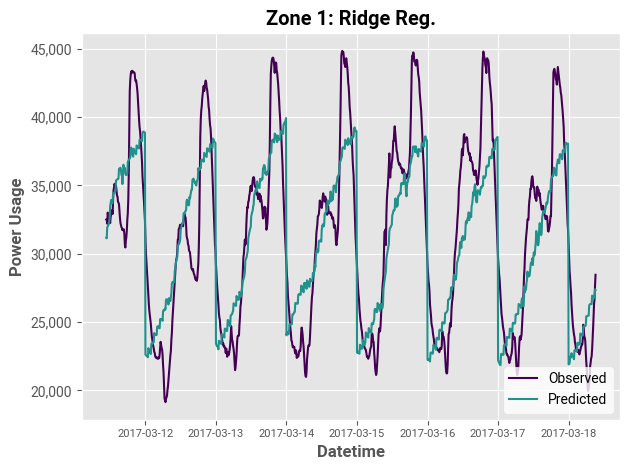

In [72]:
# Zone 1: Ridge Regression
sample = X[10000:11000]
dates = tetouan_power["datetime"][10000:11000]

pred = z1_rr.predict(sample)
output_space = np.linspace(0,  999, num=1000)

fig, ax = plt.subplots()

ax.plot(dates, y[10000:11000], color=viridis_cf[0], label="Observed")
ax.plot(dates, pred, color=viridis_cf[2], label="Predicted")


ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
[i.set_fontsize(8) for i in ax.get_xticklabels()]
ax.set_xlabel("Datetime")
ax.set_ylabel("Power Usage")
ax.set_title("Zone 1: Ridge Reg.")


plt.legend(loc='lower right')
fig.tight_layout()
plt.show()

In [73]:
# Calculate the log-likelihood
def log_likelihood(model, y, X):
    k = len(model.coef_) + 1
    n = len(y)

    residuals = y - model.predict(X)
    mse = metrics.mean_squared_error(y, model.predict(X))
    return k, -n/2 * np.log(2*np.pi) - n/2 * np.log(mse) - 1/(2*mse) * np.sum(residuals**2)


def aic(model, y, X):
    k, ll = log_likelihood(model, y, X)
    return 2*k - 2*ll

In [74]:
# Comparing AIC

print(f"AIC RR: {aic(z1_rr, y, X)}")
print(f"AIC MVLM: {lm_test_zone_1_6_cv.aic}")

AIC RR: 1024697.0046720345
AIC MVLM: 686379.9269388913


In [75]:
# Validating that the sum of zones 
lm_test_tp_6 = smf.ols(formula="total_power ~ \
                       month + day_of_week + hour + \
                       temperature + humidity + np.log(wind_speed) + \
                       general_diffuse_flows + np.sqrt(diffuse_flows)",
                           data=tetouan_power).fit()


pred_zone_sums = \
    lm_test_zone_1_6.predict(tetouan_power) + \
    lm_test_zone_2_6.predict(tetouan_power) + \
    lm_test_zone_3_6.predict(tetouan_power)

pred_tp = lm_test_tp_6.predict(tetouan_power)

# Checking for discrepancies
print(any(not x for x in pred_tp==pred_zone_sums))

# Comparing accuracy measures
print()
print("MAPE")
print(metrics.mean_absolute_percentage_error(tetouan_power["total_power"],
                                             pred_zone_sums))

print(metrics.mean_absolute_percentage_error(tetouan_power["total_power"],
                                             pred_tp))

print()
print("Exp Variance")
print(metrics.explained_variance_score(tetouan_power["total_power"],
                                       pred_zone_sums))

print(metrics.explained_variance_score(tetouan_power["total_power"],
                                       pred_tp))

print()
print("MAE")
print(np.sqrt(metrics.mean_squared_error(tetouan_power["total_power"],
                                         pred_zone_sums)))

print(np.sqrt(metrics.mean_squared_error(tetouan_power["total_power"],
                                         pred_tp)))

True

MAPE
0.11839641072882245
0.11839641072882245

Exp Variance
0.6387613833413093
0.6387613833413093

MAE
10303.464711823377
10303.464711823379


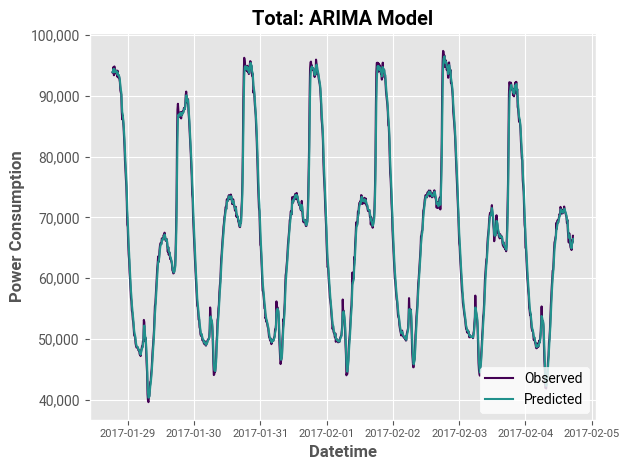

In [76]:
# Testing and ARIMA model
arima_model = ARIMA(tetouan_power["total_power"], order=(1, 1, 1)).fit()

s = 4000
e = 5000

forecast = arima_model.predict(start=s, end=e)
output_space = np.arange(e-s+1)
date_range = tetouan_power["datetime"][s-1:e]

fig, ax = plt.subplots()

ax.plot(date_range, forecast, color=viridis_cf[0], label="Observed")
ax.plot(date_range, tetouan_power['total_power'][s-1:e], color=viridis_cf[2], label="Predicted")

ax.set_xlabel("Datetime")
ax.set_ylabel("Power Consumption")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
[i.set_fontsize(8) for i in ax.get_xticklabels()]

ax.set_title("Total: ARIMA Model")
plt.legend(loc="lower right")

fig.tight_layout()
plt.show()

In [77]:
# Accuracy of ARIMA model
y_true = tetouan_power["zone_1_power"]
pred = arima_model.predict(start=0, end=tetouan_power.shape[0]-1)

# Mean absolute percentage error
np.mean(np.abs(pred - y_true)/y_true)

1.197813624505972